In [1]:
import rdkit
from torch_geometric.datasets import MoleculeNet
import seaborn as sns
import numpy as np
import pandas as pd
from IPython.display import clear_output
from sklearn.neighbors import KDTree
from scipy.spatial import cKDTree
import torch
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from torch import nn
import torch_geometric.nn as geom_nn
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset
import copy
from IPython.display import clear_output
from sklearn.model_selection import train_test_split

In [2]:
def particle_shift(particles,shift=10):

    ### Y shift ###
    y_pos = particles.copy()
    y_pos["y"] = particles["y"]+shift

    y_neg = particles.copy()
    y_neg["y"] = particles["y"]-shift

    ### Z shift ###
    z_pos = particles.copy()
    z_pos["z"] = particles["z"]+shift

    z_neg = particles.copy()
    z_neg["z"] = particles["z"]-shift

    ### Diagonal shifts ###
    ### y_pos_z_pos ###
    y_pos_z_pos = particles.copy()
    y_pos_z_pos["y"] = particles["y"]+shift
    y_pos_z_pos["z"] = particles["z"]+shift

    ### y_pos_z_neg ###
    y_pos_z_neg = particles.copy()
    y_pos_z_neg["y"] = particles["y"]+shift
    y_pos_z_neg["z"] = particles["z"]-shift

    ### y_neg_z_pos ###
    y_neg_z_pos = particles.copy()
    y_neg_z_pos["y"] = particles["y"]-shift
    y_neg_z_pos["z"] = particles["z"]+shift

    ### y_neg_z_neg ###
    y_neg_z_neg = particles.copy()
    y_neg_z_neg["y"] = particles["y"]-shift
    y_neg_z_neg["z"] = particles["z"]-shift

    return pd.concat([particles,y_pos,y_neg,z_pos,z_neg,y_pos_z_pos,y_pos_z_neg,y_neg_z_pos,y_neg_z_neg])

### array Differences function ###

def array_difference(array1,array2):
    ### First one must be the bigger array ###
    set1 = set(map(tuple, array1))
    set2 = set(map(tuple, array2))
    
    # Find the set difference
    set_difference = set1 - set2

    # Convert the set difference back to a NumPy array
    return np.array(list(set_difference))

def add_const_parameter(data,const_param):

    ### Given a numpy array of size m*n , it will return a numpy array of size m*(n+1), where
    ### the last column has all elements as const_param ###

    add_column = np.ones(len(data))*const_param
    
    return np.hstack((data, add_column[:,None]))


def mirror_edge_index(edge_index):

    first_row = edge_index[0:1, :]
    second_row = edge_index[1:, :]
    output_tensor = np.concatenate((second_row, first_row), axis=0)
    
    return np.concatenate((edge_index,output_tensor),axis=1)


def weighted_averaging(data):
    
    idx = np.where(data[0][:,4]==0)[0]
    deg_1 = data[0][idx,1:4].sum()

    idx = np.where(data[0][:,4]==1)[0]
    deg_2 = data[0][idx,1:4].sum()

    idx = np.where(data[0][:,4]==2)[0]
    deg_3 = data[0][idx,1:4].sum()

    return deg_1 + 0.5*deg_2 + 0.25*deg_3 


def merge_columns_to_pandas_list(pandas_list,variable_list,master_dataframe):

    """ given a list of pandas dataframe with the x,y,z locations and re and phi ,this function will
        merge each pandas dataframe from the list with the master dataframe with all the columns  
    """

    joined = copy.deepcopy(pandas_list)

    for i in range(len(joined)):
        print("Particle number : ",str(i+1))
        
        temp = copy.deepcopy(joined[i])

        add = pd.merge(temp,master_dataframe,how="inner",on=['Center_x','Re'],sort=False)[variable_list]
        joined[i] = pd.concat([temp,add], axis=1)

        clear_output(wait=True)
        
    return joined


def generator(all_particles,dev_particles,sf,master_dataframe):

    ### Given the pandas data of developed particles and all the particles including the particle shifted for periodicity ###
    ### This functions works for one dataset for a particular solid fraction at a time ###
    ### Master dataframe for the particular aspect ratio needs to be input to combine with the other 
    
    tree = cKDTree(all_particles.values)
    idx = np.stack([tree.query(dev_particles.iloc[i][["x","y","z"]].values,16)[1] for i in range(len(dev_particles))])
    input_dat = np.stack([all_particles.iloc[idx[i]] for i in range(len(idx))])

    ### Adding solid fraction column ###
    input_dat = [add_const_parameter(input_dat[i],sf) for i in range(len(input_dat))]

    ### Adding 4 Reynolds numbers and combining the datasets ###
    input_dat = np.vstack( ( np.stack( [add_const_parameter(input_dat[i],10) for i in range(len(input_dat))] ),
                              np.stack( [add_const_parameter(input_dat[i],50) for i in range(len(input_dat))] ),
                              np.stack( [add_const_parameter(input_dat[i],100) for i in range(len(input_dat))] ),
                              np.stack( [add_const_parameter(input_dat[i],200) for i in range(len(input_dat))] ),
                    ) )
    input_dat = [ pd.DataFrame( input_dat[i],columns=["Center_x","Center_y","Center_z","Phi","Re"]) for i in range(len(input_dat)) ]
    
    ### Joing with df array to get inclination and drag and other quantities if needed ###
    input_dat = merge_columns_to_pandas_list(pandas_list=input_dat ,variable_list=["AR","Inclination_angle","Drag_local"],master_dataframe=master_dataframe)
    input_dat = [ np.concatenate( (input_dat[i][["Center_x","Center_y","Center_z","Inclination_angle"]].values.flatten()
                                       ,input_dat[i].iloc[0][["AR","Phi","Re","Drag_local"]].values) )  for i in range(len(input_dat))]

    return input_dat

def dist_euclidean(vec_1,vec_2):

    return np.sqrt( (vec_1[0]-vec_2[0])**2 + (vec_1[1]-vec_2[1])**2 + (vec_1[2]-vec_2[2])**2 )

def brute_search(query,tree,n_nearest=16):

    ### finds the nearest neighbors with a basic algorithm ###
    ### both query and the 'tree' must be numpy arrays ###
    
    dist = np.stack([dist_euclidean(query,tree[i]) for i in range(len(tree))])

    return np.argsort(dist)[0:n_nearest]

In [5]:
### Reading Raw Data ###
all_particles_2p5 = pd.read_csv('all_particle_data_files/AR2p5_all_particle_drag.dat.csv', header=0)
all_particles_5 = pd.read_csv('all_particle_data_files/AR5_all_particle_drag.dat.csv', header=0)
all_particles_10 = pd.read_csv('all_particle_data_files/AR10_all_particle_drag.dat.csv', header=0)
all_tags_with_case_no = np.load("quick_load/all_tags_with_case_no.npy")

In [5]:
### Ar=5 Sf=0.1 case 1 ###
np.save("all_particle_data_files/center_phi_10_5_case_1.dat",
all_particles_5[(all_particles_5["phi"]==10)&(all_particles_5["case"]==2)&(all_particles_5["Re"]==10)].values[:,2:11])

### Ar=5 Sf=0.1 case 2 ###
np.save("all_particle_data_files/center_phi_10_5_case_2.dat",
all_particles_5[(all_particles_5["phi"]==10)&(all_particles_5["case"]==3)&(all_particles_5["Re"]==10)].values[:,2:11])

### Ar=5 Sf=0.2 case 1 ###
np.save("all_particle_data_files/center_phi_20_5_case_1.dat",
all_particles_5[(all_particles_5["phi"]==20)&(all_particles_5["case"]==1)&(all_particles_5["Re"]==10)].values[:,2:11])

### Ar=5 Sf=0.2 case 2 ###
np.save("all_particle_data_files/center_phi_20_5_case_2.dat",
all_particles_5[(all_particles_5["phi"]==20)&(all_particles_5["case"]==3)&(all_particles_5["Re"]==10)].values[:,2:11])

### Ar=5 Sf=0.3 case 1 ###
np.save("all_particle_data_files/center_phi_30_5_case_1.dat",
all_particles_5[(all_particles_5["phi"]==30)&(all_particles_5["case"]==1)&(all_particles_5["Re"]==10)].values[:,2:11])

### Ar=5 Sf=0.3 case 2 ###
np.save("all_particle_data_files/center_phi_30_5_case_2.dat",
all_particles_5[(all_particles_5["phi"]==30)&(all_particles_5["case"]==2)&(all_particles_5["Re"]==10)].values[:,2:11])

In [6]:
### Ar=10 Sf=0.1 case 1 ###
np.save("all_particle_data_files/center_phi_10_10_case_1.dat",
all_particles_10[(all_particles_10["phi"]==10)&(all_particles_10["case"]==1)&(all_particles_10["Re"]==10)].values[:,2:11])

### Ar=10 Sf=0.1 case 2 ###
np.save("all_particle_data_files/center_phi_10_10_case_2.dat",
all_particles_10[(all_particles_10["phi"]==10)&(all_particles_10["case"]==2)&(all_particles_10["Re"]==10)].values[:,2:11])

# ### Ar=10 Sf=0.15 case 1 ###
np.save("all_particle_data_files/center_phi_15_10_case_1.dat",
all_particles_10[(all_particles_10["phi"]==15)&(all_particles_10["case"]==1)&(all_particles_10["Re"]==10)].values[:,2:11])

# ### Ar=10 Sf=0.15 case 2 ###
np.save("all_particle_data_files/center_phi_15_10_case_2.dat",
all_particles_10[(all_particles_10["phi"]==15)&(all_particles_10["case"]==2)&(all_particles_10["Re"]==10)].values[:,2:11])

# ### Ar=10 Sf=0.2 case 1 ###
np.save("all_particle_data_files/center_phi_20_10_case_1.dat",
all_particles_10[(all_particles_10["phi"]==20)&(all_particles_10["case"]==1)&(all_particles_10["Re"]==10)].values[:,2:11])

# ### Ar=10 Sf=0.2 case 2 ###
np.save("all_particle_data_files/center_phi_20_10_case_2.dat",
all_particles_10[(all_particles_10["phi"]==20)&(all_particles_10["case"]==2)&(all_particles_10["Re"]==10)].values[:,2:11])

AR = 2.5

In [248]:
### Read all center data ###
center_10 = pd.DataFrame(np.loadtxt("all_particle_data_files/center_phi_10_2p5.dat"))
center_10 = center_10.rename(columns={ center_10.columns[3]: "x" , center_10.columns[4]: "y" , center_10.columns[5]: "z"  })
center_10_dev = center_10[(center_10['x']>7.5) & (center_10['x']<17.5)]

center_20 = pd.DataFrame(np.loadtxt("all_particle_data_files/center_phi_20_2p5.dat"))
center_20 = center_20.rename(columns={ center_20.columns[3]: "x" , center_20.columns[4]: "y" , center_20.columns[5]: "z"  })
center_20_dev = center_20[(center_20['x']>7.5) & (center_20['x']<17.5)]

center_30 = pd.DataFrame(np.loadtxt("all_particle_data_files/center_phi_30_2p5.dat"))
center_30 = center_30.rename(columns={ center_30.columns[3]: "x" , center_30.columns[4]: "y" , center_30.columns[5]: "z"  })
center_30_dev = center_30[(center_30['x']>7.5) & (center_30['x']<17.5)]

# ### Defining all particles ###
center_shifted_10 = particle_shift(center_10,shift=10)[['x','y','z']]
center_shifted_20 = particle_shift(center_20,shift=10)[['x','y','z']]
center_shifted_30 = particle_shift(center_30,shift=10)[['x','y','z']]

In [249]:
input_dat_sf10_ar2p5 = generator(all_particles=center_shifted_10, dev_particles=center_10_dev ,sf=0.1, master_dataframe=all_particles_2p5)
input_dat_sf20_ar2p5 = generator(all_particles=center_shifted_20, dev_particles=center_20_dev ,sf=0.2, master_dataframe=all_particles_2p5)
input_dat_sf30_ar2p5 = generator(all_particles=center_shifted_30, dev_particles=center_30_dev ,sf=0.3, master_dataframe=all_particles_2p5)

### Combine all subsets to form the ar=2.5 dataset ###
all_data_ar2p5 = input_dat_sf10_ar2p5 + input_dat_sf20_ar2p5 + input_dat_sf30_ar2p5

Particle number :  2300


In [250]:
### start here ###

In [180]:
all_particles_2p5 = pd.read_csv('all_particle_data_files/AR2p5_all_particle_drag.dat.csv', header=0)
verify_2p5 = pd.DataFrame(all_particles_2p5[["AR","phi","Re","case","Center_x","Center_y","Center_z","Inclination_angle","Drag_local"]])
verify_2p5 = verify_2p5.rename(columns={ verify_2p5.columns[4]: "x" , verify_2p5.columns[5]: "y" , verify_2p5.columns[6]: "z"  })
verify_2p5 = particle_shift(verify_2p5)

all_particles_5 = pd.read_csv('all_particle_data_files/AR5_all_particle_drag.dat.csv', header=0)
verify_5 = pd.DataFrame(all_particles_5[["AR","phi","Re","case","Center_x","Center_y","Center_z","Inclination_angle","Drag_local"]])
verify_5 = verify_5.rename(columns={ verify_5.columns[4]: "x" , verify_5.columns[5]: "y" , verify_5.columns[6]: "z"  })
verify_5 = particle_shift(verify_5)


all_particles_10 = pd.read_csv('all_particle_data_files/AR10_all_particle_drag.dat.csv', header=0)
verify_10 = pd.DataFrame(all_particles_10[["AR","phi","Re","case","Center_x","Center_y","Center_z","Inclination_angle","Drag_local"]])
verify_10 = verify_10.rename(columns={ verify_10.columns[4]: "x" , verify_10.columns[5]: "y" , verify_10.columns[6]: "z"  })
verify_10 = particle_shift(verify_10)

In [181]:
### Verify Ar2p5 ###

### specify case of the experiment ###
case = 1
decision_coords_inclination = list()
decision_drag = list()

### Specify solid fraction ###
data_in_use = np.array(input_dat_sf30_ar2p5)

for i in range(len(data_in_use)):
    
    print("particle number : ",str(i+1))
    verify_reduced = verify_2p5[(verify_2p5["Re"]==data_in_use[i][-2])&(verify_2p5["phi"]==data_in_use[i][-3]*100)&(verify_2p5["case"]==case)]
    indx = brute_search(data_in_use[i][0:3],verify_reduced[["x","y","z"]].values,n_nearest=16)
    neighbors = verify_reduced.iloc[indx]
    decision_coords_inclination.append(np.array_equal( data_in_use[i][0:64].reshape(16,4),neighbors[["x","y","z","Inclination_angle"]]  ) )
    decision_drag.append( np.array_equal(data_in_use[i][-1],neighbors.iloc[0]["Drag_local"]) )
    clear_output(wait=True)

np.unique(decision_coords_inclination),np.unique(decision_drag)

(array([ True]), array([ True]))

In [182]:
### Verify Ar5 ###
### specify case of the experiment ###
case = 2
decision_coords_inclination = list()
decision_drag = list()

### Specify solid fraction ###
data_in_use = np.array(input_dat_sf30_case_2_ar5)

for i in range(len(data_in_use)):
    
    print("particle number : ",str(i+1))
    verify_reduced = verify_5[(verify_5["Re"]==data_in_use[i][-2])&(verify_5["phi"]==data_in_use[i][-3]*100)&(verify_5["case"]==case)]
    indx = brute_search(data_in_use[i][0:3],verify_reduced[["x","y","z"]].values,n_nearest=16)
    neighbors = verify_reduced.iloc[indx]
    decision_coords_inclination.append(np.array_equal( data_in_use[i][0:64].reshape(16,4),neighbors[["x","y","z","Inclination_angle"]]  ) )
    decision_drag.append( np.array_equal(data_in_use[i][-1],neighbors.iloc[0]["Drag_local"]) )
    clear_output(wait=True)

np.unique(decision_coords_inclination),np.unique(decision_drag)

(array([ True]), array([ True]))

In [183]:
### Verify Ar10 ###
### specify case of the experiment ###
case = 2
decision_coords_inclination = list()
decision_drag = list()

### Specify solid fraction ###
data_in_use = np.array(input_dat_sf20_case_2_ar10)

for i in range(len(data_in_use)):
    
    print("particle number : ",str(i+1))
    verify_reduced = verify_10[(verify_10["Re"]==data_in_use[i][-2])&(verify_10["phi"]==data_in_use[i][-3]*100)&(verify_10["case"]==case)]
    indx = brute_search(data_in_use[i][0:3],verify_reduced[["x","y","z"]].values,n_nearest=16)
    neighbors = verify_reduced.iloc[indx]
    decision_coords_inclination.append(np.array_equal( data_in_use[i][0:64].reshape(16,4),neighbors[["x","y","z","Inclination_angle"]]  ) )
    decision_drag.append( np.array_equal(data_in_use[i][-1],neighbors.iloc[0]["Drag_local"]) )
    clear_output(wait=True)

np.unique(decision_coords_inclination),np.unique(decision_drag)

(array([ True]), array([ True]))

In [184]:
### end here ###

AR = 5

In [251]:
### Read all center data ###

### Sf=0.1 ###
center_10_case_1 = pd.DataFrame(np.load("all_particle_data_files/center_phi_10_5_case_1.dat.npy"))
center_10_case_1 = center_10_case_1.rename(columns={ center_10_case_1.columns[3]: "x" , center_10_case_1.columns[4]: "y" , center_10_case_1.columns[5]: "z"  })
center_10_dev_case_1 = center_10_case_1[(center_10_case_1['x']>7.5) & (center_10_case_1['x']<17.5)]

center_10_case_2 = pd.DataFrame(np.load("all_particle_data_files/center_phi_10_5_case_2.dat.npy"))
center_10_case_2 = center_10_case_2.rename(columns={ center_10_case_2.columns[3]: "x" , center_10_case_2.columns[4]: "y" , center_10_case_2.columns[5]: "z"  })
center_10_dev_case_2 = center_10_case_2[(center_10_case_2['x']>7.5) & (center_10_case_2['x']<17.5)]

### Sf=0.2 ###
center_20_case_1 = pd.DataFrame(np.load("all_particle_data_files/center_phi_20_5_case_1.dat.npy"))
center_20_case_1 = center_20_case_1.rename(columns={ center_20_case_1.columns[3]: "x" , center_20_case_1.columns[4]: "y" , center_20_case_1.columns[5]: "z"  })
center_20_dev_case_1 = center_20_case_1[(center_20_case_1['x']>7.5) & (center_20_case_1['x']<17.5)]

center_20_case_2 = pd.DataFrame(np.load("all_particle_data_files/center_phi_20_5_case_2.dat.npy"))
center_20_case_2 = center_20_case_2.rename(columns={ center_20_case_2.columns[3]: "x" , center_20_case_2.columns[4]: "y" , center_20_case_2.columns[5]: "z"  })
center_20_dev_case_2 = center_20_case_2[(center_20_case_2['x']>7.5) & (center_20_case_2['x']<17.5)]

### Sf=0.3 ###
center_30_case_1 = pd.DataFrame(np.load("all_particle_data_files/center_phi_30_5_case_1.dat.npy"))
center_30_case_1 = center_30_case_1.rename(columns={ center_30_case_1.columns[3]: "x" , center_30_case_1.columns[4]: "y" , center_30_case_1.columns[5]: "z"  })
center_30_dev_case_1 = center_30_case_1[(center_30_case_1['x']>7.5) & (center_30_case_1['x']<17.5)]

center_30_case_2 = pd.DataFrame(np.load("all_particle_data_files/center_phi_30_5_case_2.dat.npy"))
center_30_case_2 = center_30_case_2.rename(columns={ center_30_case_2.columns[3]: "x" , center_30_case_2.columns[4]: "y" , center_30_case_2.columns[5]: "z"  })
center_30_dev_case_2 = center_30_case_2[(center_30_case_2['x']>7.5) & (center_30_case_2['x']<17.5)]

# ### Defining all particles ###
center_shifted_10_case_1 = particle_shift(center_10_case_1,shift=10)[['x','y','z']]
center_shifted_10_case_2 = particle_shift(center_10_case_2,shift=10)[['x','y','z']]

center_shifted_20_case_1 = particle_shift(center_20_case_1,shift=10)[['x','y','z']]
center_shifted_20_case_2 = particle_shift(center_20_case_2,shift=10)[['x','y','z']]

center_shifted_30_case_1 = particle_shift(center_30_case_1,shift=10)[['x','y','z']]
center_shifted_30_case_2 = particle_shift(center_30_case_2,shift=10)[['x','y','z']]

In [252]:
input_dat_sf10_case_1_ar5 = generator(all_particles=center_shifted_10_case_1,dev_particles=center_10_dev_case_1,sf=0.1,master_dataframe=all_particles_5)
input_dat_sf10_case_2_ar5 = generator(all_particles=center_shifted_10_case_2,dev_particles=center_10_dev_case_2,sf=0.1,master_dataframe=all_particles_5)

input_dat_sf20_case_1_ar5 = generator(all_particles=center_shifted_20_case_1,dev_particles=center_20_dev_case_1,sf=0.2,master_dataframe=all_particles_5)
input_dat_sf20_case_2_ar5 = generator(all_particles=center_shifted_20_case_2,dev_particles=center_20_dev_case_2,sf=0.2,master_dataframe=all_particles_5)

input_dat_sf30_case_1_ar5 = generator(all_particles=center_shifted_30_case_1,dev_particles=center_30_dev_case_1,sf=0.3,master_dataframe=all_particles_5)
input_dat_sf30_case_2_ar5 = generator(all_particles=center_shifted_30_case_2,dev_particles=center_30_dev_case_2,sf=0.3,master_dataframe=all_particles_5)

### Combine all subsets to form the ar=2.5 dataset ###
all_data_ar5 = input_dat_sf10_case_1_ar5 + input_dat_sf10_case_2_ar5 + input_dat_sf20_case_1_ar5 + input_dat_sf20_case_2_ar5 + input_dat_sf30_case_1_ar5 + input_dat_sf30_case_2_ar5

Particle number :  2324


In [253]:
all_data_ar5 = input_dat_sf10_case_1_ar5 + input_dat_sf10_case_2_ar5 + input_dat_sf20_case_1_ar5 + input_dat_sf20_case_2_ar5 + input_dat_sf30_case_1_ar5 + input_dat_sf30_case_2_ar5

AR=10

In [254]:
### Read all center data ###

### Sf=0.1 ###
center_10_case_1 = pd.DataFrame(np.load("all_particle_data_files/center_phi_10_10_case_1.dat.npy"))
center_10_case_1 = center_10_case_1.rename(columns={ center_10_case_1.columns[3]: "x" , center_10_case_1.columns[4]: "y" , center_10_case_1.columns[5]: "z"  })
center_10_dev_case_1 = center_10_case_1[(center_10_case_1['x']>7.5) & (center_10_case_1['x']<17.5)]

center_10_case_2 = pd.DataFrame(np.load("all_particle_data_files/center_phi_10_10_case_2.dat.npy"))
center_10_case_2 = center_10_case_2.rename(columns={ center_10_case_2.columns[3]: "x" , center_10_case_2.columns[4]: "y" , center_10_case_2.columns[5]: "z"  })
center_10_dev_case_2 = center_10_case_2[(center_10_case_2['x']>7.5) & (center_10_case_2['x']<17.5)]

### Sf=0.2 ###
center_15_case_1 = pd.DataFrame(np.load("all_particle_data_files/center_phi_15_10_case_1.dat.npy"))
center_15_case_1 = center_15_case_1.rename(columns={ center_15_case_1.columns[3]: "x" , center_15_case_1.columns[4]: "y" , center_15_case_1.columns[5]: "z"  })
center_15_dev_case_1 = center_15_case_1[(center_15_case_1['x']>7.5) & (center_15_case_1['x']<17.5)]

center_15_case_2 = pd.DataFrame(np.load("all_particle_data_files/center_phi_15_10_case_2.dat.npy"))
center_15_case_2 = center_15_case_2.rename(columns={ center_15_case_2.columns[3]: "x" , center_15_case_2.columns[4]: "y" , center_15_case_2.columns[5]: "z"  })
center_15_dev_case_2 = center_15_case_2[(center_15_case_2['x']>7.5) & (center_15_case_2['x']<17.5)]

### Sf=0.3 ###
center_20_case_1 = pd.DataFrame(np.load("all_particle_data_files/center_phi_20_10_case_1.dat.npy"))
center_20_case_1 = center_20_case_1.rename(columns={ center_20_case_1.columns[3]: "x" , center_20_case_1.columns[4]: "y" , center_20_case_1.columns[5]: "z"  })
center_20_dev_case_1 = center_20_case_1[(center_20_case_1['x']>7.5) & (center_20_case_1['x']<17.5)]

center_20_case_2 = pd.DataFrame(np.load("all_particle_data_files/center_phi_20_10_case_2.dat.npy"))
center_20_case_2 = center_20_case_2.rename(columns={ center_20_case_2.columns[3]: "x" , center_20_case_2.columns[4]: "y" , center_20_case_2.columns[5]: "z"  })
center_20_dev_case_2 = center_20_case_2[(center_20_case_2['x']>7.5) & (center_20_case_2['x']<17.5)]

# ### Defining all particles ###
center_shifted_10_case_1 = particle_shift(center_10_case_1,shift=10)[['x','y','z']]
center_shifted_10_case_2 = particle_shift(center_10_case_2,shift=10)[['x','y','z']]

center_shifted_15_case_1 = particle_shift(center_15_case_1,shift=10)[['x','y','z']]
center_shifted_15_case_2 = particle_shift(center_15_case_2,shift=10)[['x','y','z']]

center_shifted_20_case_1 = particle_shift(center_20_case_1,shift=10)[['x','y','z']]
center_shifted_20_case_2 = particle_shift(center_20_case_2,shift=10)[['x','y','z']]

In [255]:
input_dat_sf10_case_1_ar10 = generator(all_particles=center_shifted_10_case_1,dev_particles=center_10_dev_case_1,sf=0.1,master_dataframe=all_particles_10)
input_dat_sf10_case_2_ar10 = generator(all_particles=center_shifted_10_case_2,dev_particles=center_10_dev_case_2,sf=0.1,master_dataframe=all_particles_10)

input_dat_sf15_case_1_ar10 = generator(all_particles=center_shifted_15_case_1,dev_particles=center_15_dev_case_1,sf=0.15,master_dataframe=all_particles_10)
input_dat_sf15_case_2_ar10 = generator(all_particles=center_shifted_15_case_2,dev_particles=center_15_dev_case_2,sf=0.15,master_dataframe=all_particles_10)

input_dat_sf20_case_1_ar10 = generator(all_particles=center_shifted_20_case_1,dev_particles=center_20_dev_case_1,sf=0.2,master_dataframe=all_particles_10)
input_dat_sf20_case_2_ar10 = generator(all_particles=center_shifted_20_case_2,dev_particles=center_20_dev_case_2,sf=0.2,master_dataframe=all_particles_10)

### Combine all subsets to form the ar=2.5 dataset ###
all_data_ar10 = input_dat_sf10_case_1_ar10+input_dat_sf10_case_2_ar10+input_dat_sf15_case_1_ar10+input_dat_sf15_case_2_ar10+input_dat_sf20_case_1_ar10+input_dat_sf20_case_2_ar10

Particle number :  1592


In [256]:
all_data_ar10 = input_dat_sf10_case_1_ar10 + input_dat_sf10_case_2_ar10 + input_dat_sf15_case_1_ar10 + input_dat_sf15_case_2_ar10 + input_dat_sf20_case_1_ar10 + input_dat_sf20_case_2_ar10

In [298]:
all_data = all_data_ar2p5 + all_data_ar5 + all_data_ar10

all_data_pd = pd.DataFrame(all_data,columns=["POI_x_coord","POI_y_coord","POI_z_coord","inclination_poi",
                                             "neigh_1_x","neigh_1_y","neigh_1_z","inclination_1",
                                             "neigh_2_x","neigh_2_y","neigh_2_z","inclination_2",
                                             "neigh_3_x","neigh_3_y","neigh_3_z","inclination_3",
                                             "neigh_4_x","neigh_4_y","neigh_4_z","inclination_4",
                                             "neigh_5_x","neigh_5_y","neigh_5_z","inclination_5",
                                             "neigh_6_x","neigh_6_y","neigh_6_z","inclination_6",
                                             "neigh_7_x","neigh_7_y","neigh_7_z","inclination_7",
                                             "neigh_8_x","neigh_8_y","neigh_8_z","inclination_8",
                                             "neigh_9_x","neigh_9_y","neigh_9_z","inclination_9",
                                             "neigh_10_x","neigh_10_y","neigh_10_z","inclination_10",
                                             "neigh_11_x","neigh_11_y","neigh_11_z","inclination_11",
                                             "neigh_12_x","neigh_12_y","neigh_12_z","inclination_12",
                                             "neigh_13_x","neigh_13_y","neigh_13_z","inclination_13",
                                             "neigh_14_x","neigh_14_y","neigh_14_z","inclination_14",
                                             "neigh_15_x","neigh_15_y","neigh_15_z","inclination_15",
                                              "AR","Phi","Re","Drag_local"])
all_data_pd.head(5)

,POI_x_coord,POI_y_coord,POI_z_coord,inclination_poi,neigh_1_x,neigh_1_y,neigh_1_z,inclination_1,neigh_2_x,neigh_2_y,...,neigh_14_z,inclination_14,neigh_15_x,neigh_15_y,neigh_15_z,inclination_15,AR,Phi,Re,Drag_local
0,10.876728,8.580914,1.499941,32.081738,10.469863,8.375915,0.380001,59.653803,12.365468,8.985445,...,1.279047,46.541607,10.606896,9.100682,-1.328129,58.238513,2.5,0.1,10.0,3.903370
1,12.929652,8.518986,8.546638,77.315739,13.137204,7.388673,9.134358,38.412987,14.129487,8.677728,...,7.350211,61.077618,13.048629,11.408079,8.215324,63.637424,2.5,0.1,10.0,5.023779
2,17.018229,8.503029,1.464684,52.642073,15.846247,8.562797,1.726459,64.790014,17.168299,7.801587,...,1.141856,78.979347,17.064104,11.427227,1.433072,49.657668,2.5,0.1,10.0,4.573232
3,16.603652,1.499732,9.825560,60.625083,16.301634,1.485659,8.521393,87.749395,17.064104,1.427227,...,7.689390,64.057556,16.342990,4.722934,11.133123,60.235139,2.5,0.1,10.0,6.699245
4,11.737969,1.485545,9.792119,51.275008,12.637778,2.087273,10.319745,66.724320,11.783217,0.809170,...,7.937789,80.703918,11.646745,1.887016,7.009987,70.790087,2.5,0.1,10.0,7.034383


In [299]:
### Defining train and test indices (first 40 particle from each experiment) ###
check_points = np.array([0,
                         len(input_dat_sf10_ar2p5)//4,len(input_dat_sf10_ar2p5)//4,len(input_dat_sf10_ar2p5)//4,len(input_dat_sf10_ar2p5)//4,
                         len(input_dat_sf20_ar2p5)//4,len(input_dat_sf20_ar2p5)//4,len(input_dat_sf20_ar2p5)//4,len(input_dat_sf20_ar2p5)//4,
                         len(input_dat_sf30_ar2p5)//4,len(input_dat_sf30_ar2p5)//4,len(input_dat_sf30_ar2p5)//4,len(input_dat_sf30_ar2p5)//4,

                         len(input_dat_sf10_case_1_ar5)//4,len(input_dat_sf10_case_1_ar5)//4,len(input_dat_sf10_case_1_ar5)//4,len(input_dat_sf10_case_1_ar5)//4,
                         len(input_dat_sf10_case_2_ar5)//4,len(input_dat_sf10_case_2_ar5)//4,len(input_dat_sf10_case_2_ar5)//4,len(input_dat_sf10_case_2_ar5)//4,

                         len(input_dat_sf20_case_1_ar5)//4,len(input_dat_sf20_case_1_ar5)//4,len(input_dat_sf20_case_1_ar5)//4,len(input_dat_sf20_case_1_ar5)//4,
                         len(input_dat_sf20_case_2_ar5)//4,len(input_dat_sf20_case_2_ar5)//4,len(input_dat_sf20_case_2_ar5)//4,len(input_dat_sf20_case_2_ar5)//4,

                         len(input_dat_sf30_case_1_ar5)//4,len(input_dat_sf30_case_1_ar5)//4,len(input_dat_sf30_case_1_ar5)//4,len(input_dat_sf30_case_1_ar5)//4,
                         len(input_dat_sf30_case_2_ar5)//4,len(input_dat_sf30_case_2_ar5)//4,len(input_dat_sf30_case_2_ar5)//4,len(input_dat_sf30_case_2_ar5)//4,


                         len(input_dat_sf10_case_1_ar10)//4,len(input_dat_sf10_case_1_ar10)//4,len(input_dat_sf10_case_1_ar10)//4,len(input_dat_sf10_case_1_ar10)//4,
                         len(input_dat_sf10_case_2_ar10)//4,len(input_dat_sf10_case_2_ar10)//4,len(input_dat_sf10_case_2_ar10)//4,len(input_dat_sf10_case_2_ar10)//4,

                         len(input_dat_sf15_case_1_ar10)//4,len(input_dat_sf15_case_1_ar10)//4,len(input_dat_sf15_case_1_ar10)//4,len(input_dat_sf15_case_1_ar10)//4,
                         len(input_dat_sf15_case_2_ar10)//4,len(input_dat_sf15_case_2_ar10)//4,len(input_dat_sf15_case_2_ar10)//4,len(input_dat_sf15_case_2_ar10)//4,

                         len(input_dat_sf20_case_1_ar10)//4,len(input_dat_sf20_case_1_ar10)//4,len(input_dat_sf20_case_1_ar10)//4,len(input_dat_sf20_case_1_ar10)//4,
                         len(input_dat_sf20_case_2_ar10)//4,len(input_dat_sf20_case_2_ar10)//4,len(input_dat_sf20_case_2_ar10)//4,len(input_dat_sf20_case_2_ar10)//4,

                        ]).cumsum() 

test_indices = np.stack([np.arange(40) + check_points[i] for i in range(len(check_points)-1)]).flatten()
train_indices = np.setdiff1d( np.arange(len(all_data)) , test_indices )

In [300]:
### Basic Data ###
### All the locations are wrt the global coordinates ###

### Scaling the data ###
train_data_pd = all_data_pd.iloc[train_indices]
test_data_pd = all_data_pd.iloc[test_indices]

scaler = MinMaxScaler()
scaler.fit(train_data_pd)

train_data_pd_scaled = scaler.transform(train_data_pd)
test_data_pd_scaled = scaler.transform(test_data_pd)
all_data_pd_scaled = scaler.transform(all_data_pd)

### splitting to input and outputs ##3
train_inputs,train_inputs_global,train_outputs = train_data_pd_scaled[:,0:64],train_data_pd_scaled[:,64:67],train_data_pd_scaled[:,67:]
test_inputs,test_inputs_global,test_outputs = test_data_pd_scaled[:,0:64],test_data_pd_scaled[:,64:67],test_data_pd_scaled[:,67:]

### Saving the data ###
### Train ###
np.save("quick_load/first_40/train_inputs_MLP",train_inputs)
np.save("quick_load/first_40/train_inputs_global",train_inputs_global)
np.save("quick_load/first_40/train_outputs_MLP",train_outputs)

# ### Test ###
np.save("quick_load/first_40/test_inputs_MLP",test_inputs)
np.save("quick_load/first_40/test_inputs_global",test_inputs_global)
np.save("quick_load/first_40/test_outputs_MLP",test_outputs)

# ### All Data ###
np.save("quick_load/first_40/all_data_gnn",all_data_pd_scaled)
np.save("quick_load/first_40/train_indices",train_indices)
np.save("quick_load/first_40/test_indices",test_indices)

### Save min and max drag values ###
np.save("quick_load/first_40/min_max_drags", np.array([scaler.data_min_[-1],scaler.data_max_[-1]]) )

In [301]:
### Local Data ###

### All the locations are wrt to the coordinates of the POI ###
### location translation ###
all_data_pd_local = all_data_pd.copy()

### x-coordinate ###
neigh_columns = [col for col in all_data_pd.columns if col.startswith('neigh_') and col.endswith('_x')]
for col in neigh_columns:
    all_data_pd_local[col] = all_data_pd['POI_x_coord'] - all_data_pd[col]

### x-coordinate ###
neigh_columns = [col for col in all_data_pd.columns if col.startswith('neigh_') and col.endswith('_y')]
for col in neigh_columns:
    all_data_pd_local[col] = all_data_pd['POI_y_coord'] - all_data_pd[col]

### x-coordinate ###
neigh_columns = [col for col in all_data_pd.columns if col.startswith('neigh_') and col.endswith('_z')]
for col in neigh_columns:
    all_data_pd_local[col] = all_data_pd['POI_z_coord'] - all_data_pd[col]


### Scaling the data ###
train_data_pd = all_data_pd_local.iloc[train_indices]
test_data_pd = all_data_pd_local.iloc[test_indices]

scaler = MinMaxScaler()
scaler.fit(train_data_pd)

train_data_pd_scaled = scaler.transform(train_data_pd)
test_data_pd_scaled = scaler.transform(test_data_pd)
all_data_pd_scaled = scaler.transform(all_data_pd_local)

### splitting to input and outputs ##3
train_inputs,train_inputs_global,train_outputs = train_data_pd_scaled[:,0:64],train_data_pd_scaled[:,64:67],train_data_pd_scaled[:,67:]
test_inputs,test_inputs_global,test_outputs = test_data_pd_scaled[:,0:64],test_data_pd_scaled[:,64:67],test_data_pd_scaled[:,67:]

### Saving the data ###
### Train ###
np.save("quick_load/first_40_local_coordinates/train_inputs_MLP",train_inputs)
np.save("quick_load/first_40_local_coordinates/train_inputs_global",train_inputs_global)
np.save("quick_load/first_40_local_coordinates/train_outputs_MLP",train_outputs)

# ### Test ###
np.save("quick_load/first_40_local_coordinates/test_inputs_MLP",test_inputs)
np.save("quick_load/first_40_local_coordinates/test_inputs_global",test_inputs_global)
np.save("quick_load/first_40_local_coordinates/test_outputs_MLP",test_outputs)

# ### All Data ###
np.save("quick_load/first_40_local_coordinates/all_data_gnn_local_coord",all_data_pd_scaled)
np.save("quick_load/first_40_local_coordinates/train_indices",train_indices)
np.save("quick_load/first_40_local_coordinates/test_indices",test_indices)

### Save min and max drag values ###
np.save("quick_load/first_40_local_coordinates/min_max_drags", np.array([scaler.data_min_[-1],scaler.data_max_[-1]]) )

In [302]:
### Defining train and test indices (setting an experiment with all Reynolds numbers as test dataset) ###

Ar=5
Sf=0.2
Re=100
case=1

test_indices = np.where((all_tags_with_case_no[:,0]==Ar)&(all_tags_with_case_no[:,1]==Sf)&(all_tags_with_case_no[:,3]==case))
train_indices = np.setdiff1d( np.arange(len(all_data)) , test_indices )

In [303]:
### Single experiment split basic data ###
### All the locations are wrt the global coordinates ###

### Scaling the data ###
train_data_pd = all_data_pd.iloc[train_indices]
test_data_pd = all_data_pd.iloc[test_indices]

scaler = MinMaxScaler()
scaler.fit(train_data_pd)

train_data_pd_scaled = scaler.transform(train_data_pd)
test_data_pd_scaled = scaler.transform(test_data_pd)
all_data_pd_scaled = scaler.transform(all_data_pd)

### splitting to input and outputs ##3
train_inputs,train_inputs_global,train_outputs = train_data_pd_scaled[:,0:64],train_data_pd_scaled[:,64:67],train_data_pd_scaled[:,67:]
test_inputs,test_inputs_global,test_outputs = test_data_pd_scaled[:,0:64],test_data_pd_scaled[:,64:67],test_data_pd_scaled[:,67:]

### Saving the data ###
### Train ###
np.save("quick_load/single_experiment_ar5_sf_20_case_1/train_inputs_MLP",train_inputs)
np.save("quick_load/single_experiment_ar5_sf_20_case_1/train_inputs_global",train_inputs_global)
np.save("quick_load/single_experiment_ar5_sf_20_case_1/train_outputs_MLP",train_outputs)

# ### Test ###
np.save("quick_load/single_experiment_ar5_sf_20_case_1/test_inputs_MLP",test_inputs)
np.save("quick_load/single_experiment_ar5_sf_20_case_1/test_inputs_global",test_inputs_global)
np.save("quick_load/single_experiment_ar5_sf_20_case_1/test_outputs_MLP",test_outputs)

# ### All Data ###
np.save("quick_load/single_experiment_ar5_sf_20_case_1/all_data_gnn",all_data_pd_scaled)
np.save("quick_load/single_experiment_ar5_sf_20_case_1/train_indices",train_indices)
np.save("quick_load/single_experiment_ar5_sf_20_case_1/test_indices",test_indices)

### Save min and max drag values ###
np.save("quick_load/single_experiment_ar5_sf_20_case_1/min_max_drags", np.array([scaler.data_min_[-1],scaler.data_max_[-1]]) )

Done

Generate from Ze time series dataset 

In [10]:
import itertools

def get_periodic_coordinates(coord, size):
    """
    Generate all coordinates within a cubic domain considering periodic boundary conditions.
    
    Parameters:
        coord (pandas dataframe): A pandas dataframe containing the columns (x, y, z) of a point.
        size (int): The size of the cubic domain along each axis.
    Returns:
        list: A list of tuples containing all coordinates within the cubic domain.
    """
    # Get coordinates ###
    if isinstance(coord, pd.DataFrame):
        coord = coord[["x","y","z"]].values

    # Generate all combinations of displacements (-1, 0, 1) along each axis
    displacements = list(itertools.product([-1, 0, 1], repeat=3))

    # Generate all coordinates by applying periodic boundary conditions
    tp_coordinates = list()
    
    for i in range(len(coord)):
        
        x, y, z = coord[i,0],coord[i,1],coord[i,2]  
        temp = list()
        
        for dx, dy, dz in displacements:
            
            new_x = x + dx*size
            new_y = y + dy*size
            new_z = z + dz*size

            temp.append((new_x,new_y,new_z))
            
        tp_coordinates.append( np.array(temp) )
    
    return np.vstack(tp_coordinates)

In [11]:
def group_time_series_data(time_series_data):
    
    """
    Groups the data based on case_ID and time 
    
    Parameters:
       time_series_data (pandas dataframe) : obtained from Ze's final data directory 
    Returns:
        list: A list of pandas dataframes each with a unique case id and time-stamp
    """
    ### load raw data from ze time series data ###
    pd_list  = list()
    
    for (col1_val, col2_val), group in time_series_data.groupby(['case_ID', 'time']):
    
        pd_list.append(group)
    
    return pd_list

In [12]:
def generate_nearest_neighbor_data(time_series_data):

    """
    Wrapper function (in some sense, can be condensed more)to do the data generation 
    
    Parameters:
       time_series_data (pandas dataframe) : obtained from Ze's final data directory 
    Returns:
        list: A list of pandas dataframes each with a unique case id and time-stamp
    """
    
    pd_list = group_time_series_data(time_series_data)
    
    nearest_neighbor_data = list()
    scalar_data = list()
    
    ### Loop over different groups ###
    
    for i in range(len(pd_list)):

        tp_particles = get_periodic_coordinates(pd_list[i],5)
        tree = cKDTree(tp_particles)

        ### Loop over all particles in a group and getting the nearest neighbors ###
        idx = np.stack([ tree.query(pd_list[i].iloc[j][["x","y","z"]].values,16)[1] for j in range(len(pd_list[i])) ])
        nearest_neighbor_data.append(tp_particles[idx])

        ### Getting the scalar data ###
        scalar_data.append( pd_list[i][["Density_ratio","glb_phi","glb_Re","local_Re","Drag"]] )

    nearest_neighbor_data = np.stack(nearest_neighbor_data)
    nearest_neighbor_data = nearest_neighbor_data.reshape(nearest_neighbor_data.shape[0]*nearest_neighbor_data.shape[1]
                                           ,nearest_neighbor_data.shape[2]*nearest_neighbor_data.shape[3])
    
    scalar_data = np.stack(scalar_data)
    scalar_data = scalar_data.reshape(scalar_data.shape[0]*scalar_data.shape[1],scalar_data.shape[2])    
    
    return np.concatenate( (nearest_neighbor_data,scalar_data) ,axis=1)

In [9]:
### Read data ###
time_series_data = pd.read_csv("Ze_time_series/final_data/final_data/rho10_30percent_Re10.dat")
pd_list = group_time_series_data(time_series_data)
nearest_neighbor_data = generate_nearest_neighbor_data(time_series_data)
# nearest_neighbor_data,scalar_data = generate_nearest_neighbor_data(time_series_data)

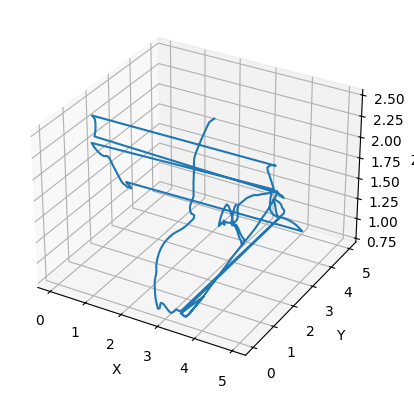

In [39]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_trajectory(coordinates):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    x = coordinates[:, 0]
    y = coordinates[:, 1]
    z = coordinates[:, 2]
    
    ax.plot(x, y, z)
    
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    
    plt.show()

plot_trajectory(temp)

In [19]:
### Splitting the data as test and train (Random) ###
# X_train, X_test, y_train, y_test = train_test_split(nearest_neighbor_data[:,0:48],nearest_neighbor_data[:,48:], test_size=0.2, random_state=1)

### Splitting the data as test and train (Random) ###
X_train, X_test = nearest_neighbor_data[0:24480,0:48],nearest_neighbor_data[24480:,0:48]
y_train, y_test = nearest_neighbor_data[0:24480,48:],nearest_neighbor_data[24480:,48:]

### Scaling the data ###
### Inputs ###
scaler = MinMaxScaler()
scaler.fit(X_train)

train_input_scaled = scaler.transform(X_train)
test_input_scaled = scaler.transform(X_test)

### Scalar Inputs and outputs (both are under outputs and thus needs to be separated during saving) ###
scaler = MinMaxScaler()
scaler.fit(y_train)

train_output_scaled = scaler.transform(y_train)
test_output_scaled = scaler.transform(y_test)

In [20]:
np.save("Ze_time_series/quick_load/case_split/train_input",train_input_scaled.reshape(train_input_scaled.shape[0],16,3))
np.save("Ze_time_series/quick_load/case_split/test_input",test_input_scaled.reshape(test_input_scaled.shape[0],16,3))

np.save("Ze_time_series/quick_load/case_split/train_input_scalar",train_output_scaled[:,0:4])
np.save("Ze_time_series/quick_load/case_split/test_input_scalar",test_output_scaled[:,0:4])

np.save("Ze_time_series/quick_load/case_split/train_output",train_output_scaled[:,4:])
np.save("Ze_time_series/quick_load/case_split/test_output",test_output_scaled[:,4:])

End here

Generate from Ze time series dataset (Radius based neighbors and first and second degree neighbors connections)

In [13]:
def array_difference(array1,array2):
    
    ### First one must be the bigger array ###
    set1 = set(map(tuple, array1))
    set2 = set(map(tuple, array2))
    
    # Find the set difference
    set_difference = set1 - set2

    # Convert the set difference back to a NumPy array
    return np.array(list(set_difference))

In [14]:
def reshape_to_2d(array):
    """
    Reshape an n-dimensional NumPy array to a 2D array, flattening all dimensions except the last one.

    Parameters:
        array (numpy.ndarray): Input n-dimensional array.

    Returns:
        numpy.ndarray: Reshaped 2D array.
    """
    # Flatten all dimensions except the last one
    new_shape_first_dim = np.prod(array.shape[:-1])
    
    # Keep the last dimension intact
    new_shape_second_dim = array.shape[-1]

    # Reshape the array
    reshaped_array = array.reshape(new_shape_first_dim, new_shape_second_dim)

    return reshaped_array

In [15]:
def generate_nearest_neighbor_data_neigh_levels(poi,tp_particles,num_levels=3,neigh_per_level=[5,3,2]):

    """
    Wrapper function to do the data generation 
    
    Parameters:
       poi (pandas dataframe) : coordinates of the particle of interest 
       tp_particles : the set of all particles (inlcuding particles obatined from peridic shifting)
       num_levels : num of levels of neighborhood/shells wanted (at least 2)
       neigh_per_level : number of neighbors to search per neighborhood/shell
       
    Returns:
        : numpy array with the nearest neighbors and their corresponding index
        : edge indexs, which is a an a tensor of all how all the neighbors are connected
    """

    ### Defining KDtree ###
    tree = KDTree(tp_particles)
    
    ### Loop over different groups ###
    nearest_neighbor_data = list()
    
    for i in range(num_levels):
        
        ### Define query point/points ###
        if i==0:
            
            idx = tree.query(poi,neigh_per_level[0],return_distance=False,sort_results=True)
            nearest_neighbor_data.append(tp_particles[idx][0][1:])
            
            particles_to_remove = np.concatenate( (poi,np.stack(nearest_neighbor_data)[0]) )
            remaining_particles = array_difference(tp_particles,particles_to_remove)
        
        if i>0:
                                                   
            tree = KDTree(remaining_particles)
            query_points = reshape_to_2d( nearest_neighbor_data[-1] ) 

            ### get nearest neighbors ###
            idx = [ tree.query(query_points[j][None,:],neigh_per_level[i],return_distance=False,sort_results=True) for j in range(len(query_points)) ]
            
            nearest_neighbor_data.append(remaining_particles[idx].squeeze(1))

            particles_to_remove = np.concatenate( ( particles_to_remove , reshape_to_2d(nearest_neighbor_data[-1]) ) ) 
            remaining_particles = array_difference(remaining_particles,particles_to_remove)

    ### Correcting the shape of the first element ###
    nearest_neighbor_data[0] = nearest_neighbor_data[0][None,:,:]
        
    return nearest_neighbor_data

In [16]:
### Read data ###
time_series_data = pd.read_csv("Ze_time_series/final_data/final_data/rho100_30percent_Re200.dat")
pd_list = group_time_series_data(time_series_data)
tp_particles = get_periodic_coordinates(pd_list[0],5)

In [17]:
n=11
tp_particles = get_periodic_coordinates(pd_list[n],5)

for i in range(pd_list[n].shape[0]):
    nearest_neighbor_data = generate_nearest_neighbor_data_neigh_levels(pd_list[n].iloc[i][["x","y","z"]].values[None,:],tp_particles)
    break
    # print( np.unique(reshape_to_2d(nearest_neighbor_data[2]),axis=0).shape )

In [24]:
def generate_list_of_indices(poi,nearest_neighbor_data):

    all_involved_particles = np.concatenate( (poi,
                                          reshape_to_2d(nearest_neighbor_data[0]),
                                          reshape_to_2d(nearest_neighbor_data[1]),
                                          reshape_to_2d(nearest_neighbor_data[2]) ) )

    indexes = np.unique(all_involved_particles,axis=0,return_index=True)[1]
    all_involved_particles = np.stack([all_involved_particles[index] for index in sorted(indexes)])
    
    all_involved_particles = np.concatenate( ( np.arange(len(all_involved_particles))[:,None], all_involved_particles ),axis=1 )
    all_involved_particles_pd = pd.DataFrame(all_involved_particles,columns=[["Particle No","x","y","z"]])

    return all_involved_particles_pd

In [18]:
all_involved_particles = np.concatenate( (pd_list[n].iloc[i][["x","y","z"]].values[None,:],
                                          reshape_to_2d(nearest_neighbor_data[0]),
                                          reshape_to_2d(nearest_neighbor_data[1]),
                                          reshape_to_2d(nearest_neighbor_data[2]) ) )

indexes = np.unique(all_involved_particles,axis=0,return_index=True)[1]
all_involved_particles = np.stack([all_involved_particles[index] for index in sorted(indexes)])

all_involved_particles = np.concatenate( ( np.arange(len(all_involved_particles))[:,None], all_involved_particles ),axis=1 )
all_involved_particles_pd = pd.DataFrame(all_involved_particles,columns=[["Particle No","x","y","z"]])

In [19]:
def generate_connections(index_list,particle_of_origin,connected_particles):

    ### idx of the particle of origin ### 
    idx=(index_list["x"].values==particle_of_origin[0])&(index_list["y"].values==particle_of_origin[1])&(index_list["z"].values==particle_of_origin[2])
    origin_id = index_list.iloc[idx]["Particle No"].values[0][0]

    origin_id = index_list.iloc[idx]["Particle No"].values[0][0]

    ### idx of the connected particles ### 
    idx=np.stack( [ (index_list["x"].values==connected_particles[i][0])
         &(index_list["y"].values==connected_particles[i][1])
         &(index_list["z"].values==connected_particles[i][2]) for i in range(len(connected_particles))] )
    
    connected_id = [ index_list.iloc[idx[i]]["Particle No"].values[0][0]  for i in range(len(idx))]

    return origin_id,connected_id

In [22]:
num_levels=3
neigh_per_level=[5,3,2]
edge_index = list()

for i in range(num_levels-1):

    previous_level = reshape_to_2d( nearest_neighbor_data[i] )
    next_level =  nearest_neighbor_data[i+1] 
    break
    for i in range(len(previous_level)):

        edge_index.append( generate_connections(index_list = all_involved_particles_pd,
                             particle_of_origin = previous_level[i],
                             connected_particles = next_level) )
        

In [23]:
origin_id,connected_id = generate_connections(index_list=all_involved_particles_pd,
                     particle_of_origin=previous_level[i],connected_particles=next_level[i])

In [117]:
import numpy as np
import plotly.graph_objs as go
from IPython.display import display
from plotly.io import write_html


poi = np.array( [tp_particles[n]] )
deg_1 = nearest_neighbor_data[1].reshape(nearest_neighbor_data[1].shape[0]*nearest_neighbor_data[1].shape[1],3)
deg_2 = nearest_neighbor_data[2].reshape(nearest_neighbor_data[2].shape[0]*nearest_neighbor_data[2].shape[1],3)

### Create 3D scatter plot
fig = go.Figure(data=[go.Scatter3d(
    x=[poi[0][0] ],
    y=[poi[0][1] ],
    z=[poi[0][2] ],
    mode='markers',
    marker=dict(
        size=12,
        color="green",                # set color to the z coordinate
        opacity=0.8
    )
)])

# # Add trace for data2
fig.add_trace(go.Scatter3d(
    x=deg_1[:,0],
    y=deg_1[:,1],
    z=deg_1[:,2],
    mode='markers',
    marker=dict(
        size=12,             
        color='red',  
        opacity=0.2
    ),
    name='Data 2'
))


fig.add_trace(go.Scatter3d(
    x=deg_2[:,0],
    y=deg_2[:,1],
    z=deg_2[:,2],
    mode='markers',
    marker=dict(
        size=12,    
        color='blue',
        opacity=0.9
    ),
    name='Data 2'
))

# # Update layout
fig.update_layout(scene=dict(
    xaxis_title='X Axis Title',
    yaxis_title='Y Axis Title',
    zaxis_title='Z Axis Title'
))

# Show plot
fig.show()
write_html(fig, file="scatter_plot.html")

End Here

In [27]:
### Preparing GNN data ###
all_data_graph_struct = list()

edge_index = torch.tensor([[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                           [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]])

for i in range(len(all_data_pd)):

    ### setting inputs ###
    x = torch.tensor(all_data_pd_scaled[i][0:64].reshape(16,4)).float().clone().detach()
    
    ### adding drag force as y ###
    y = torch.tensor(all_data_pd_scaled[i][-1][None,None]).float().clone().detach()
    
    # all_data_graph_struct.append(Data(x=x , edge_index=torch.tensor(mirror_edge_index(edge_index)) , y=y))
    all_data_graph_struct.append(Data(x=x.clone().detach() , edge_index=edge_index.clone().detach() , y=y.clone().detach()))

In [ ]:
### Sf=0.20 case_2 ###
### Generating the n nearest neighbors ###
all_particles = center_shifted_20_case_2.copy()
dev_particles = center_20_dev_case_2.copy()

tree = cKDTree(all_particles.values)
idx = np.stack([tree.query(dev_particles.iloc[i][["x","y","z"]].values,16)[1] for i in range(len(dev_particles))])
input_dat = np.stack([all_particles.iloc[idx[i]] for i in range(len(idx))])

### Adding solid fraction column ###
input_dat = [add_const_parameter(input_dat[i],0.20) for i in range(len(input_dat))]

### Adding 4 Reynolds numbers and combining the datasets ###
input_dat = np.vstack( ( np.stack( [add_const_parameter(input_dat[i],10) for i in range(len(input_dat))] ),
                              np.stack( [add_const_parameter(input_dat[i],50) for i in range(len(input_dat))] ),
                              np.stack( [add_const_parameter(input_dat[i],50) for i in range(len(input_dat))] ),
                              np.stack( [add_const_parameter(input_dat[i],50) for i in range(len(input_dat))] ),
                    ) )
input_dat = [ pd.DataFrame( input_dat[i],columns=["Center_x","Center_y","Center_z","Phi","Re"]) for i in range(len(input_dat)) ]

### Joing with df array to get inclination and drag and other quantities if needed ###
input_dat = merge_columns_to_pandas_list(pandas_list=input_dat ,variable_list=["Inclination_angle","Drag_local"],master_dataframe=df)
input_dat_sf20_ar10_case_2 = [ np.concatenate( (input_dat[i][["Center_x","Center_y","Center_z","Inclination_angle"]].values.flatten()
                                       ,input_dat[i].iloc[0][["Phi","Re","Drag_local"]].values) )  for i in range(len(input_dat))]

In [ ]:
# case_list = np.concatenate((all_particles_2p5[ (all_particles_2p5["Center_x"]>7.5) & (all_particles_2p5["Center_x"]<17.5) ]["case"].values[:,None],
# all_particles_5[ (all_particles_5["Center_x"]>7.5) & (all_particles_5["Center_x"]<17.5) ]["case"].values[:,None],
# all_particles_10[ (all_particles_10["Center_x"]>7.5) & (all_particles_10["Center_x"]<17.5) ]["case"].values[:,None]),axis=0)

# all_tags_with_case = np.concatenate((all_tags,case_list),axis=1)
# all_tags_with_case
# np.save("quick_load/all_tags_with_case_no.npy",all_tags_with_case)